In [154]:
using Catalyst, Symbolics, Plots, DifferentialEquations
include("../src/SynthEvo.jl")
C = SynthEvo.make_FullyConnectedNonExplosive_CRN(3)
println("done")

x = nothing
input = 1
u0 = [0. for _ in 1:243]
control0 = [input]
p0 = [1. for i in 1:80]
t0 = 10.
t1 = 20.
perturbation_list = [i+1 for i in 1:12]

base_problem_ext = SynthEvo.make_base_problem(C, C.ext_ode, u0, control0, p0, t0, true, 0.1)
base_problem_ode = SynthEvo.make_base_problem(C, C.ode, u0[1:3], control0, p0, t0, true, 0.1)

loss1 = SynthEvo.adaptation_loss(C, 2, 3, 10., 20.)
loss2 = SynthEvo.sensitivity_loss(C, 2, 3, 0.25, 10., 10.5)
loss3 = SynthEvo.steady_state_loss(C, 2, 10., 20., 6, 16.)
loss4 = SynthEvo.regularization_loss(C, 1)
l = SynthEvo.weighted_loss([loss1, loss2, loss3, loss4], [10,10,100,0.1])

gd_options = (
    n_iter = 100,
    verbose = false,
    use_random_perturbation = false, # TODO maybe move to perturbation_options
    use_pruning_heuristic = false,
    clip_value = nothing,
    use_gradient_normalization = false,
    use_gradient_noise = false,
    alpha = 0.01,
    use_adam = false,
    ADAM_beta1 = 0.9,
    ADAM_beta2 = 0.9,
    use_adagrad = true
)

gd_perturbation_options = (
    t0 = t0,
    t1 = t1,
    loss_fun = l,
    input = input,
    perturbation_list = [i+1 for i in 1:12]
)

ga_options = (
    genetic_pool_size = 100,
    elite = 10,
    worst = 20,
    death_rate = 0.05,
    mutation_rate = 0.30,
    gradient_mutation_rate = 0.01,
    duplication_rate = 0.20,
    crossover_rate = 0.,
    max_generations = 100,
    p_cross = 0.1,
    dp = 0.05,
)

ga_options_NFB = (
    genetic_pool_size = 100,
    elite = 0,
    worst = 0,
    death_rate = (rank) -> 0.0*(rank),
    mutation_rate = (rank) -> 0.50,
    gradient_mutation_rate = (rank) -> 0.02*(1-rank),
    duplication_rate = (rank) -> 0.0*(1-rank),
    crossover_rate = (rank) -> 0.0*(1-rank),
    max_generations = 100,
    p_cross = 0.1,
    dp = 0.05,
)

ga_perturbation_options = (
    use_random_perturbation = false,
    t0 = t0,
    t1 = t1,
    loss_fun = l,
    input = input,
    perturbation_list = [i+1 for i in 1:12]
)

mutate_with_GD = (p) -> SynthEvo.symbolic_gradient_descent(p, C, gd_options, gd_perturbation_options).parameters

ga_loss = SynthEvo.prepare_GA_loss(C, base_problem_ode, ga_perturbation_options)

print("setup done!")

done


setup done!

In [155]:
# initialize the state
state = SynthEvo.initialize_state(C.number_of_parameters, ga_options)
print("done")

done

In [156]:
@time out = SynthEvo.runp_SF_CPU(C, base_problem_ode, state.pool, ga_perturbation_options.t0, ga_perturbation_options.t1, perturbation_list)
nothing

  0.606591 seconds (661.67 k allocations: 83.182 MiB, 78.81% compilation time)


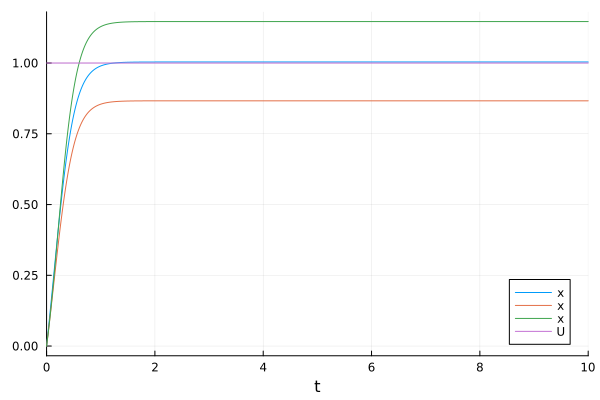

In [157]:
plot(out[1][1])

In [158]:
@time out = ga_loss(state)
nothing

  1.653136 seconds (1.79 M allocations: 125.134 MiB, 449.31% compilation time)


In [159]:
# using ProgressBars
# max_generations = ga_options.max_generations
# for i in ProgressBar(1:max_generations)
#     state = SynthEvo.symbolic_evolve(ga_loss, state, mutate_with_GD, ga_options)
# end

using ProgressBars
max_generations = ga_options.max_generations
output_degradation_parameter = 29
for i in ProgressBar(1:max_generations)
    state = SynthEvo.symbolic_evolve_NFB(ga_loss, state, mutate_with_GD, ga_options_NFB, output_degradation_parameter, 0.1)
end

0.0%┣                                              ┫ 0/100 [00:00<00:00, -0s/it]
1.0%┣▍                                         ┫ 1/100 [00:00<Inf:Inf, InfGs/it]
2.0%┣█                                              ┫ 2/100 [00:01<01:16, 1it/s]
3.0%┣█▍                                             ┫ 3/100 [00:07<05:57, 4s/it]
4.0%┣█▉                                             ┫ 4/100 [00:08<04:04, 3s/it]
5.0%┣██▍                                            ┫ 5/100 [00:14<05:33, 4s/it]
6.0%┣██▉                                            ┫ 6/100 [00:14<04:28, 3s/it]
7.0%┣███▎                                           ┫ 7/100 [00:17<04:29, 3s/it]
8.0%┣███▊                                           ┫ 8/100 [00:18<03:53, 3s/it]
9.0%┣████▎                                          ┫ 9/100 [00:18<03:24, 2s/it]
10.0%┣████▌                                        ┫ 10/100 [00:21<03:31, 2s/it]
11.0%┣█████                                        ┫ 11/100 [00:21<03:10, 2s/it]
12.0%┣█████▍                

# OLDER STUFF

In [160]:
minimum(state.history.mean_loss)

3.8063812005075444

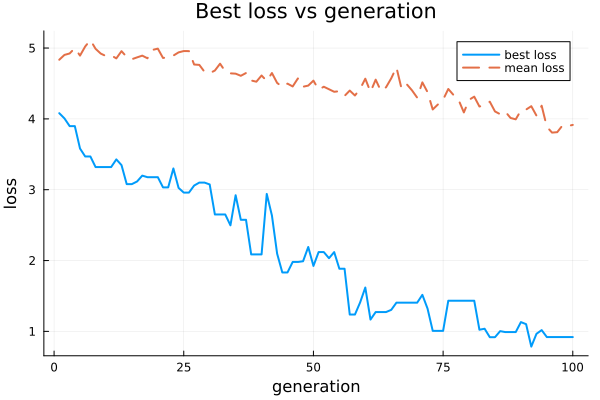

In [161]:
plot(state.history.best_loss, label="best loss", xlabel="generation", ylabel="loss", title="Best loss vs generation", lw=2, legend=:topright)
plot!(state.history.mean_loss, label="mean loss", lw=2, line=:dash)

In [162]:
best = argmin(state.fitness)
println("Best loss: ", state.fitness[best])

Best loss: 0.9192962365121549


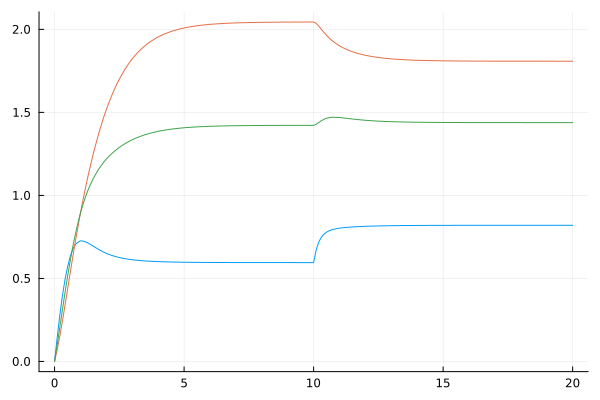

In [163]:
perturb = 2
opt_index = argmin(state.fitness)
#opt_index = 10

base_problem = SynthEvo.make_base_problem(C, C.ext_ode, u0, control0, state.pool[opt_index], t0, true, 0.1)
shared_solution, solutions = SynthEvo.run_SF_CPU(C, base_problem, t0, t1, [2], 1e-5, 1e-5, true, 0.25)
sol = SynthEvo.merge_solutions(shared_solution, solutions, 1, t0)
plot( [(t*0.1) for t in 0:200], SynthEvo.vec2mat([sol(t*0.1)[1:3] for t in 0:200]), legend=false)

# println("Optimal index: ", opt_index)
# println("Adaptation error: ", abs(sol(t0)[3] - sol(t1)[3]))
# println("sensitivity: ", abs(sol(t0)[3] - sol(t0+0.5)[3]), " and  loss : ", abs(abs(sol(t0)[3] - sol(t0+0.5)[3]) - 0.01))
# plot(sol.t, vec2mat(sol.u)[:,1:4], label=["X1" "X2" "X3 (output)" "U"], lw=1.5, title="Dynamics of the optimal particle", xlabel="time", ylabel="concentration")

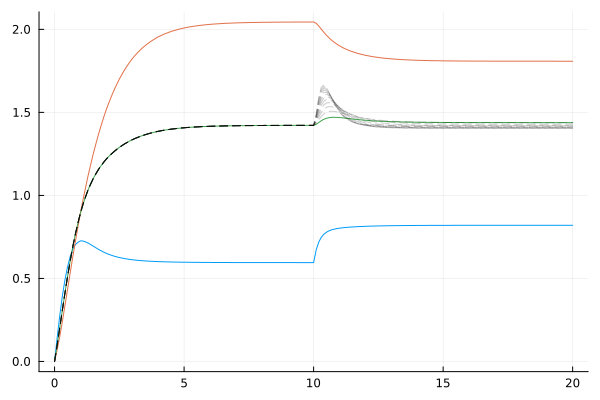

In [164]:
base_problem = SynthEvo.make_base_problem(C, C.ext_ode, u0, control0, state.pool[opt_index], t0, true, 0.1)
shared_solution, solutions = SynthEvo.run_SF_CPU(C, base_problem, t0, t1, perturbation_list, 1e-5, 1e-5, true, 0.25)

for i in 1:length(solutions)
    sol = SynthEvo.merge_solutions(shared_solution, solutions, i, t0)
    if i == 1
        plot( [(t*0.1) for t in 0:200], SynthEvo.vec2mat([sol(t*0.1)[1:3] for t in 0:200]), legend=false)
    else
        plot!( [(t*0.1) for t in 0:200], [sol(t*0.1)[3] for t in 0:200], legend=false, color=:black, linestyle=:dash, alpha=0.2)
    end
end
plot!()

In [10]:
# zoom on reaction 3
plot(sol.t, vec2mat(sol.u)[:,3], label="X3 Output", xlabel="time", ylabel="concentration", title="Dynamics of the optimal particle (zoom)", lw=2, color=3)
xlims!(t0-1., t0+2)
ylims!(sol(t0-1)[3]-sol(t0-1)[3]*0.3, sol(t0+2)[3]+sol(t0+2)[3]*0.3)

UndefVarError: UndefVarError: `sol` not defined

In [11]:
gd_options_for_output = (
    alpha = gd_options.alpha,
    n_iter = gd_options.n_iter,
    use_pruning_heuristic = gd_options.use_pruning_heuristic,
    clip_value = gd_options.clip_value,
    use_gradient_normalization = gd_options.use_gradient_normalization,
    use_adagrad = gd_options.use_adagrad, # overrides use_adam!
    use_adam = gd_options.use_adam,
    use_random_perturbation = gd_options.use_random_perturbation,
    verbose = true,
    # placed here for convenience, should be in gd_loss_options
    symbolic_derivatives_of_loss = gd_options.symbolic_derivatives_of_loss
)
out = symbolic_gradient_descent(state.pool[best], crn_info, gd_options_for_output, gd_perturbation_options, gd_loss_options)

UndefVarError: UndefVarError: `gd_options` not defined

In [12]:
plot(1:length(out.loss_tape), out.loss_tape, label="loss", xlabel="iteration", ylabel="loss", title="Loss vs iteration", lw=2, legend=:bottomright)

UndefVarError: UndefVarError: `out` not defined

In [174]:
using Symbolics
using LinearAlgebra
function joint_jacobian(i, j, jac, initial_conditions)
    A_ij = substitute(jac[i, j], initial_conditions)
    return A_ij
end

opt_index = 1
# opt_index = argmin(predictions)
# opt_index = length(loss_tape)

opt_pars_v = state.pool[opt_index]
opt_pars_l = Dict()
for i in 1:length(opt_pars_v)
    opt_pars_l[C.parameters[i]] = opt_pars_v[i]
end


jac = Symbolics.substitute(calculate_jacobian(C.ode), (opt_pars_l))

perturb = 2.5

base_problem = SynthEvo.make_base_problem(C, C.ext_ode, u0, control0, state.pool[opt_index], t0, true, 0.1)
shared_solution, solutions = SynthEvo.run_SF_CPU(C, base_problem, t0, t1, [2], 1e-5, 1e-5, true, 0.25)
sol = SynthEvo.merge_solutions(shared_solution, solutions, 1, t0)

steady_state_after_perturbation = sol(t1)[1:3]
steady_state_after_perturbation = [
    C.species[1] => steady_state_after_perturbation[1],
    C.species[2] => steady_state_after_perturbation[2],
    C.species[3] => steady_state_after_perturbation[3]
]

A_21 = joint_jacobian(2, 1, jac, steady_state_after_perturbation)
A_32 = joint_jacobian(3, 2, jac, steady_state_after_perturbation)
A_22 = joint_jacobian(2, 2, jac, steady_state_after_perturbation)
A_31 = joint_jacobian(3, 1, jac, steady_state_after_perturbation)

println("A_21 = ", A_21)
println("A_32 = ", A_32)
println("A_22 = ", A_22)
println("A_31 = ", A_31)
println("A_22*A_31 = ", A_22*A_31)
println("A_21*A_32 = ", A_21*A_32)
println("A_22*A_31 - A_21*A_32 = ", A_22*A_31 - A_21*A_32)

A_21 = -1.7414296665802629
A_32 = 1.2981772475616677
A_22 = -1.7935905455117462
A_31 = 1.3288281606502763
A_22*A_31 = -2.3833736255520996
A_21*A_32 = -2.2606843713833986
A_22*A_31 - A_21*A_32 = -0.12268925416870102


In [14]:
# homeostatic_coefs_A21_A32 = []
# homeostatic_coefs_A22_A31 = []
# homeostatic_coefs = []

# for par_set in state.pool
#     opt_pars_v = par_set
#     opt_pars_l = assemble_opt_parameters_and_varables(opt_pars_v, N)

#     jac = Symbolics.substitute(calculate_jacobian(ode_crn), unsym_dict(opt_pars_l.p))

#     perturb = 2.5
#     steady_state_after_perturbation = run_extended_with_fixed_perturbations(ext_ode, opt_pars_l, 1., [ perturb ], t0, t1)[1](t1)[1:3]
#     steady_state_after_perturbation = [
#         :x_1 => steady_state_after_perturbation[1],
#         :x_2 => steady_state_after_perturbation[2],
#         :x_3 => steady_state_after_perturbation[3]
#     ]

#     A_21 = joint_jacobian(2, 1, jac, steady_state_after_perturbation)
#     A_32 = joint_jacobian(3, 2, jac, steady_state_after_perturbation)
#     A_22 = joint_jacobian(2, 2, jac, steady_state_after_perturbation)
#     A_31 = joint_jacobian(3, 1, jac, steady_state_after_perturbation)

#     push!(homeostatic_coefs_A21_A32, A_21*A_32)
#     push!(homeostatic_coefs_A22_A31, A_22*A_31)
#     push!(homeostatic_coefs, A_22*A_31 - A_21*A_32)
# end

In [15]:
# histogram([x.val for x in homeostatic_coefs], label=false, xlabel="Homeostatic coefficient", ylabel="frequency", title="Homeostatic coefficient distribution", lw=0.5, legend=:bottomright)

In [16]:
# histogram([x.val for x in homeostatic_coefs_A21_A32], label=false, xlabel="A_21*A_32", ylabel="frequency", title="Homeostatic coefficient distribution", lw=1, legend=:bottomright)

In [17]:
# histogram([x.val for x in homeostatic_coefs_A22_A31], label=false, xlabel="A_21*A_32", ylabel="frequency", title="Homeostatic coefficient distribution", lw=0.5, legend=:bottomright)

In [18]:
# histogram([ x.val for x in homeostatic_coefs_A21_A32 + homeostatic_coefs_A22_A31], xlabel="A21_A32 + A22_A31", ylabel="frequency", title="Homeostatic coefficient distribution", lw=1, legend=false)

In [19]:
# plot([x.val for x in homeostatic_coefs_A22_A31], [x.val for x in homeostatic_coefs_A21_A32], seriestype = :scatter, xlabel="A_22*A_31", ylabel="A_21*A_32", title="Components of the homeostatic coefficient", lw=2, legend=:bottomright, alpha=0.5)
# xlims!(-85,0)
# ylims!(-60,0)

In [20]:
opt_index_options = [best, rand(1:length(state.pool)), 1]
opt_index_options_labels = ["min loss", "$(opt_index_options[2])", "1"]
opt_index_options_colors = [:red, :green, :blue]

hists = []
for i in 1:length(opt_index_options)
    opt_index = opt_index_options[i]
    opt_pars_v = state.pool[opt_index]
    opt_pars_l = assemble_opt_parameters_and_varables(opt_pars_v, 3)
    h = histogram(opt_pars_v, label=opt_index_options_labels[i], xlabel="Parameter value", ylabel="Frequency", title=opt_index_options_labels[i], lw=2, legend=false, color=opt_index_options_colors[i], bins=20)
    push!(hists, h)
end
plot(hists..., layout=(1,3))

UndefVarError: UndefVarError: `best` not defined

In [21]:
# using Pkg; Pkg.add("JLD2")

In [22]:
using JLD2

save_object("Ultra-Sensitivity.jld2", Dict(
    "state" => state,
    # all parameters 
    "ga_options" => Dict(
        genetic_pool_size => genetic_pool_size,
        elite => elite,
        worst => worst,
        death_rate => death_rate,
        mutation_rate => mutation_rate,
        gradient_mutation_rate => gradient_mutation_rate,
        duplication_rate => duplication_rate,
        crossover_rate => crossover_rate,
        max_generations => max_generations,
        p_cross => p_cross
    ),
    "crn_info" => crn_info,
    "gd_loss_options" => gd_loss_options,
    "gd_options" => gd_options,
    "gd_perturbation_options" => gd_perturbation_options
))    


UndefVarError: UndefVarError: `state` not defined

In [23]:
# test_load = load_object("Ultra-Sensitivity.jld2") 